===================================================  

INFERENCE

===================================================


# Library

In [1]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score,confusion_matrix
import re
import string
import tensorflow as tf
import tensorflow_hub as tf_hub
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import TextVectorization,Embedding, Concatenate, Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

# Inference

In [2]:
#loading data
inf = pd.read_csv('https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_komentar_instagram_cyberbullying.csv')
inf

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...,...
395,396,positive,Bangga sama suami yg selalu ingat istri disela...
396,397,positive,Apaoun pekerjaannya yg penting halal u tuk men...
397,398,positive,Gojek itu mayoritas pegangguran yang lama gak ...
398,399,positive,<USERNAME> aslinya cantik dan ayu loh mbak kr...


Data loaded successfully

In [3]:
# Create a function for text preprocessing

#syntax for stopwords
stw = pd.read_csv('https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/stopword_tweet_pilkada_DKI_2017.csv')
stpwds_id = stw.values.tolist()
stpwds_id.append(['ada'])

# syntax for stemmer
stemmer = StemmerFactory().create_stemmer()

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [4]:
#text preprocessing
inf['text_processed'] = inf['Instagram Comment Text'].apply(lambda x: text_preprocessing(x))


In [5]:
#text preprocessing results
inf

,Id,Sentiment,Instagram Comment Text,text_processed
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,username tolol gak ada hubung nya gugur dgn pa...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata cowo bgt bela in balik hadeww n...
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn mewek skr lengket lg duhhh kok labil bgt ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ...",inti kalau kesel dengan att nya gausah ke anak...
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hade permpuan itu lg sakit jiwa knp harus dia ...
...,...,...,...,...
395,396,positive,Bangga sama suami yg selalu ingat istri disela...,bangga sama suami yg selalu ingat istri sela w...
396,397,positive,Apaoun pekerjaannya yg penting halal u tuk men...,apaoun kerja yg penting halal u tuk nafkah kel...
397,398,positive,Gojek itu mayoritas pegangguran yang lama gak ...,gojek itu mayoritas pegangguran yang lama gak ...
398,399,positive,<USERNAME> aslinya cantik dan ayu loh mbak kr...,username asli cantik dan ayu loh mbak krn aku ...


In [6]:
#drop unused columns
inf.drop(['Id','Instagram Comment Text'],axis=1,inplace=True)
inf

,Sentiment,text_processed
0,negative,username tolol gak ada hubung nya gugur dgn pa...
1,negative,geblek lo tata cowo bgt bela in balik hadeww n...
2,negative,kmrn mewek skr lengket lg duhhh kok labil bgt ...
3,negative,inti kalau kesel dengan att nya gausah ke anak...
4,negative,hade permpuan itu lg sakit jiwa knp harus dia ...
...,...,...
395,positive,bangga sama suami yg selalu ingat istri sela w...
396,positive,apaoun kerja yg penting halal u tuk nafkah kel...
397,positive,gojek itu mayoritas pegangguran yang lama gak ...
398,positive,username asli cantik dan ayu loh mbak krn aku ...


In [7]:
#encode target
inf['Sentiment'] = inf['Sentiment'].replace({'negative' : 0, 'positive' : 1})
inf

,Sentiment,text_processed
0,0,username tolol gak ada hubung nya gugur dgn pa...
1,0,geblek lo tata cowo bgt bela in balik hadeww n...
2,0,kmrn mewek skr lengket lg duhhh kok labil bgt ...
3,0,inti kalau kesel dengan att nya gausah ke anak...
4,0,hade permpuan itu lg sakit jiwa knp harus dia ...
...,...,...
395,1,bangga sama suami yg selalu ingat istri sela w...
396,1,apaoun kerja yg penting halal u tuk nafkah kel...
397,1,gojek itu mayoritas pegangguran yang lama gak ...
398,1,username asli cantik dan ayu loh mbak krn aku ...


In [8]:
#split x and  y data
inf_x = inf.drop('Sentiment',axis=1)
inf_y = inf['Sentiment']

In [9]:
#load model
from keras.models import load_model
model = load_model('best_model.keras')

In [11]:
predict = model.predict(inf_x)
prediction = np.where(predict > 0.3,1,0)

13/13 [==============================] - 1s 13ms/step


In [12]:
# classification report result
print(classification_report(prediction, inf_y))

              precision    recall  f1-score   support

           0       0.98      0.54      0.69       367
           1       0.15      0.91      0.26        33

    accuracy                           0.57       400
   macro avg       0.57      0.72      0.48       400
weighted avg       0.92      0.57      0.66       400



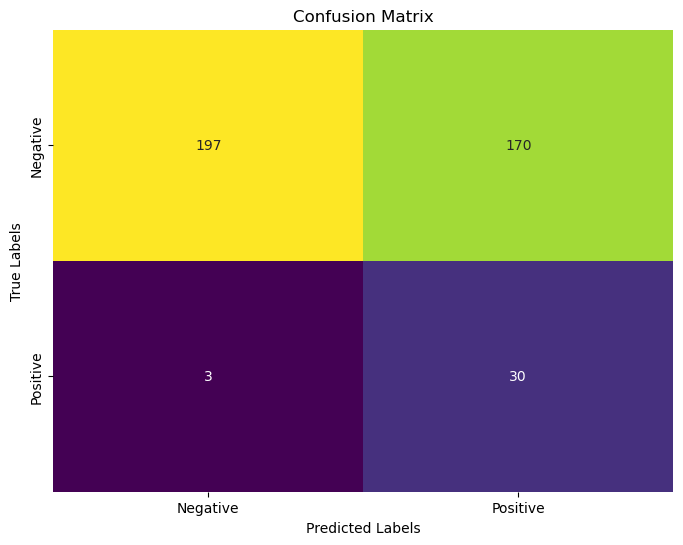

In [13]:
#heatmap
cm = confusion_matrix(prediction, inf_y)

# Create a heatmap from the confusion matrix with the viridis color scheme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The model can run on inference data. However, because the data used is different from data about the 2017 regional elections, the model has poor prediction results.